In [1]:
import glob
import json

#following are the preprocessing steps to get all the data in a single string.
file = []
tunes = []
alltunes = []
# change the location of the dataset accordingly when running.
for i in glob.glob("/content/drive/MyDrive/Thesis/Data_Final/*.json"): 
  with open(i,"r") as x:
    file = json.load(x)
    tunes.append(file["rows"])


In [2]:
alltunes = [ i for j in tunes for i in j]

In [3]:
len(alltunes)

20458

In [4]:
demo = [[j for i in l for j in i ]for l in alltunes]

In [5]:
list = ['a','b','c','d','e','f','g','z','A','B','C','D','E','F','G','1','2','3','4','5','6','7',"'",'^',',','_','/','=']

In [6]:
filter = [[] for _ in range(len(demo))]
for i in range(len(demo)):
  for j in range(len(demo[i])):
    if demo[i][j] in list:
      filter[i].append(demo[i][j])


In [7]:
list = [[] for _ in range(len(filter))]
for i in range(len(filter)):
    list[i].append("".join(filter[i]))
    

In [8]:
musicdata = [ i for j in list for i in j]

final_tunes =(''.join(musicdata))



In [9]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import glob
from sklearn.preprocessing import MinMaxScaler
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Dropout, Bidirectional,LSTM,Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import random
random.seed(0)


In [10]:
# get the unique characters from the string
notes = sorted(set(final_tunes))
print("The length of the unique characters is :", len(notes))

The length of the unique characters is : 28


In [11]:
def prepare_sequences(tune):
    """ Prepare the sequences used by the Neural Network """
    vocab = sorted(set(tune))
    length = len(vocab)

    
    convert2int = {u:i for i, u in enumerate(vocab)}
    input = []
    output = []

    # create sequences to pass to model
    for i in range(0, len(tune) - length, 1):
        seq_input = tune[i:i + length]
        seq_output = tune[i + length]
        input.append([convert2int[char] for char in seq_input])
        output.append(convert2int[seq_output])

    char_length = len(input)

    # Reshape for passing to LSTM layer
    input = np.reshape(input, (char_length, length, 1))

    #vectorizing the data between 0 to 1

    maxNote = np.percentile(input,95)
    minNote = np.percentile(input,5)

    input = -1 + 2*(input - minNote)/(maxNote - minNote)


    return (input, output,minNote,maxNote)

In [ ]:
class GAN():
    def __init__(self, rows):
        self.length = rows
        self.shape = (self.length, 1)
        self.latent_dimension = 100
        self.discriminator_loss = []
        self.generator_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(1,self.latent_dimension))
        sequence = self.generator(z)

        # Combined Model
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(sequence)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

   
    
    def build_discriminator(self):
        model = Sequential()
        model.add(LSTM(512,return_sequences=True,input_shape = self.shape))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        seq = Input(shape=self.shape)
        validity = model(seq)

        return Model(seq, validity)                

    def build_generator(self):
        model = Sequential()
        model.add(LSTM(512,input_shape = (1,self.latent_dimension),return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dropout(0.6))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.prod(self.shape), activation='tanh'))
        model.add(Reshape(self.shape))
        model.summary()
        
        noise = Input(shape=(1,self.latent_dimension))
        seq = model(noise)

        return Model(noise, seq)

    def train(self,final_tunes, epochs, batch_size=60, sample_interval=50):

        # Load and convert the data
        notes = final_tunes
        n_vocab = len(set(final_tunes))
        X_train, y_train,min,max = prepare_sequences(notes)
        # Training the model
        for epoch in range(epochs+1):
          for _ in range(1):
            dloss = self.train_discriminator(X_train,batch_size)
          gloss = self.train_generator(batch_size)

          if(epoch  %  sample_interval):
            self.discriminator_loss.append(dloss[0])
            self.generator_loss.append(gloss)

            # Print the progress and save into loss lists
          if epoch % sample_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, dloss[0], 100*dloss[1], gloss))
        
        op = self.generate(notes,min,max)
        self.plot_loss()
        return op

    def train_discriminator(self, X_real, batch_size):
        half_batch = batch_size // 2

        discriminator_indices = np.random.randint(0, X_real.shape[0], half_batch)
        discriminator_train_imgs = X_real[discriminator_indices]

        noise = np.random.normal(0, 1, (half_batch, 1,self.latent_dimension))
        generated_imgs = self.generator.predict(noise)

        discriminator_loss_real = self.discriminator.train_on_batch(discriminator_train_imgs, np.ones([half_batch, 1]))
        discriminator_loss_gen = self.discriminator.train_on_batch(generated_imgs, np.zeros([half_batch, 1]))
        # average the two losses
        discriminator_loss = np.add(discriminator_loss_real, discriminator_loss_gen) / 2

        return discriminator_loss

    def train_generator(self, batch_size):
        noise = np.random.normal(0, 1, (batch_size, 1,self.latent_dimension))
        valid_y = np.array([1] * batch_size)  # move generator towards desired validity

        generator_loss = self.combined.train_on_batch(noise, valid_y)
        return generator_loss

    def generate(self, input_notes,min,max):
        # Get pitch names and store in a dictionary
        notes = input_notes
        final = []
        pitchnames = sorted(set(item for item in notes))
        idx2char = dict((number, note) for number, note in enumerate(pitchnames))
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (20,1,100))
        predictions = self.generator.predict(noise)
        predictions = 0.5 *(max-min)*(predictions+1) + min

        predictions = np.around(predictions,0).astype(np.int32)
        print('pred:',predictions)
        gan.combined.save('combined.h5')
        gan.generator.save('generator.h5')
        gan.discriminator.save('discriminator.h5')
        np.save("generated_notes.npy", predictions)
        return predictions
        


    def plot_loss(self):
        plt.plot(self.discrminator_loss, c='red')
        plt.plot(self.generator_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()

if __name__ == '__main__':
  gan = GAN(rows=len(notes))    
  op = gan.train(final_tunes,epochs=4000, sample_interval=250)

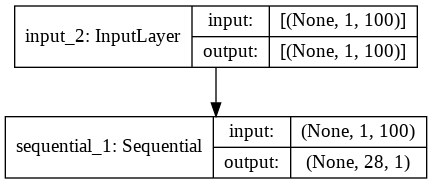

In [ ]:
tf.keras.utils.plot_model(gan.generator, to_file='imagegen.png', show_shapes=True)

In [ ]:
pitchnames = sorted(set(item for item in final_tunes))
convert = dict((number, note) for number, note in enumerate(pitchnames))
final = []
for i in range(len(op)):
  for j in range(len(op[i])):
    z = op[i][j]
    final.append(convert[z[0]])

In [ ]:
pitchnames = sorted(set(item for item in final_tunes))
convert = dict((number, note) for number, note in enumerate(pitchnames))
final = []
for i in op[0]: # to get all string replace the o with numbers from 0 to 19 and you'll get 19 strings in total
  final.append(convert[i[0]])


In [ ]:
print(final)

['b', 'B', '7', 'e', 'G', 'f', '2', '^', 'a', '_', 'G', 'G', '=', 'c', '4', 'B', 'G', 'a', 'E', '4', 'F', '3', 'e', 'F', '6', 'F', 'D', 'd', 'b', 'C', '7', 'e', 'G', 'f', '2', '^', 'a', '^', 'G', 'G', '=', 'c', '4', 'B', 'G', 'b', 'E', '5', 'F', '3', 'e', 'F', '6', 'E', 'C', 'd', 'a', 'C', '7', 'e', 'G', 'f', '2', '^', 'a', '_', 'G', 'G', '=', 'c', '4', 'C', 'G', 'b', 'E', '5', 'F', '3', 'e', 'G', '6', 'E', 'C', 'd', 'a', 'D', '7', 'e', '^', 'f', '2', '^', 'a', '_', 'G', 'E', '=', 'd', '4', 'C', '^', 'c', 'F', '5', 'G', '3', 'e', '^', '7', 'D', 'C', 'd', '_', 'B', '6', 'e', 'F', 'f', '2', 'G', 'a', '_', '^', 'G', 'A', 'd', '4', 'D', 'F', 'a', 'E', '4', 'G', '4', 'e', '^', '7', 'D', 'D', 'd', 'a', 'C', '7', 'e', '^', 'f', '2', '^', 'a', '_', 'G', 'G', 'A', 'c', '4', 'C', 'G', 'b', 'E', '5', 'F', '3', 'e', 'G', '6', 'D', 'C', 'd', 'a', 'B', '7', 'e', 'G', 'f', '2', '^', 'a', '_', '^', 'G', 'A', 'c', '4', 'C', 'G', 'a', 'E', '4', 'F', '3', 'e', 'G', '6', 'E', 'D', 'd', 'b', 'C', '7', 'e',

In [ ]:
str = ''.join([i for i in final])

print(str)

ggggfgEea4fgggggggggfgg2g2gg
